# QLDPC Contraction Analysis

我们需要评估我们的不同解码方法（不同的近似策略），在解决哪些syndrome的情况下容易出错。

外部接口的参数

In [ ]:
import numpy as np

# import cupy as cp  # 替换numpy为cupy

def sample_decode_baseline_unique_predicted_observables(unique_syndrome: np.ndarray, unique_actual_observables: np.ndarray, counts: np.ndarray):
    # Find the indices where self.syndromes matches the input syndrome
    baseline_unique_predicted_observables = []
    # print("unique_syndrome", unique_syndrome)
    for syndrome in unique_syndrome:
        matching_indices = np.all(unique_syndrome == syndrome, axis=1)
        
        # Get the corresponding actual observables for the matching syndromes
        matching_observables = unique_actual_observables[matching_indices]
        matching_counts = counts[matching_indices]
        
        # 找到最大的count及其对应的observable
        max_count_index = np.argmax(matching_counts)
        max_count = matching_counts[max_count_index]
        max_observable = matching_observables[max_count_index]
        
        # 存储结果
        baseline_unique_predicted_observables.append(max_observable)

    # Return the result: the most likely value and its confidence ratio
    return np.array(baseline_unique_predicted_observables)

from multiprocessing import Pool


def process_chunk(chunk, unique_syndrome, unique_actual_observables, counts):
    baseline_unique_predicted_observables = []
    for syndrome in chunk:
        matching_indices = np.all(unique_syndrome == syndrome, axis=1)

        # Get the corresponding actual observables for the matching syndromes
        matching_observables = unique_actual_observables[matching_indices]
        matching_counts = counts[matching_indices]

        # 找到最大的count及其对应的observable
        max_count_index = np.argmax(matching_counts)
        max_count = matching_counts[max_count_index]
        max_observable = matching_observables[max_count_index]

        # 存储结果
        baseline_unique_predicted_observables.append(max_observable)
    return np.array(baseline_unique_predicted_observables)


def sample_decode_baseline_unique_predicted_observables_parallel(unique_syndrome: np.ndarray,
                                                                 unique_actual_observables: np.ndarray,
                                                                 counts: np.ndarray,
                                                                 num_processes=4):
    # 将 unique_syndrome 分割成多个块
    chunks = np.array_split(unique_syndrome, num_processes)

    # 创建进程池
    with Pool(processes=num_processes) as pool:
        results = []
        for chunk in chunks:
            result = pool.apply_async(process_chunk,
                                      args=(chunk, unique_syndrome, unique_actual_observables, counts))
            results.append(result)

        # 获取每个进程的结果
        final_results = []
        for result in results:
            final_results.extend(result.get())

    return np.array(final_results)

# def sample_decode_baseline_unique_predicted_observables_gpu(unique_syndrome: cp.ndarray, unique_actual_observables: cp.ndarray, counts: cp.ndarray):
#     # Find the indices where self.syndromes matches the input syndrome
#     baseline_unique_predicted_observables = []
#     # print("unique_syndrome", unique_syndrome)
#     for syndrome in unique_syndrome:
#         matching_indices = cp.all(unique_syndrome == syndrome, axis=1)
        
#         # Get the corresponding actual observables for the matching syndromes
#         matching_observables = unique_actual_observables[matching_indices]
#         matching_counts = counts[matching_indices]
        
#         # 找到最大的count及其对应的observable
#         max_count_index = cp.argmax(matching_counts)
#         max_count = matching_counts[max_count_index]
#         max_observable = matching_observables[max_count_index]
        
#         # 存储结果
#         baseline_unique_predicted_observables.append(max_observable)

#     # Return the result: the most likely value and its confidence ratio
#     return cp.array(baseline_unique_predicted_observables)

def _analyze_error_syndrome(unique_syndrome, unique_actual_observables, unique_predicted_observables, baseline_unique_predicted_observables, counts):
    # 找出预测结果不同的syndrome
    diff_indices = np.where(np.any(unique_predicted_observables != baseline_unique_predicted_observables, axis=1))[0]
    diff_syndromes = unique_syndrome[diff_indices]
    actual = unique_actual_observables[diff_indices]
    predicted = unique_predicted_observables[diff_indices]
    baseline_predicted = baseline_unique_predicted_observables[diff_indices]
    diff_syndrome_counts = counts[diff_indices]
    
    # 返回不同预测结果的统计信息
    return {
        'diff_count': len(diff_indices),
        'diff_syndromes': diff_syndromes,
        'actual': actual,
        'predicted': predicted,
        'baseline_predicted': baseline_predicted,
        'diff_syndrome_counts': diff_syndrome_counts,
    }

from eamld.benchmark import LogicalErrorRateBenchmark

def analyze_decode_performance(decoder_function, baseline_decoder_function, d, nkd, r, p, noise_model, error_type, num_runs, data_path, code_name):
    # 初始化基准测试
    if d == None:
        d = nkd[2]
    
    benchmark = LogicalErrorRateBenchmark(
        decoder_function = decoder_function,
        d = d,
        nkd = nkd,
        r = r,
        p = p,
        noise_model = noise_model,
        error_type = error_type,
        num_runs = num_runs,
        data_path = data_path,
        code_name = code_name
    )
    benchmark.run()
    # 获取结果
    unique_syndrome = benchmark.unique_syndrome
    unique_actual_observables = benchmark.unique_actual_observables
    counts = benchmark.counts
    unique_predicted_observables = benchmark.unique_predicted_observables
    print("finish decoding")
    if baseline_decoder_function == None:
        # baseline_unique_predicted_observables = sample_decode_baseline_unique_predicted_observables(unique_syndrome, unique_actual_observables, counts)
        # cupy_unique_syndrome = cp.asarray(unique_syndrome)
        # cupy_unique_actual_observables = cp.asarray(unique_actual_observables)
        # cupy_counts = cp.asarray(counts)
        # print("finish cupy")
        baseline_unique_predicted_observables = sample_decode_baseline_unique_predicted_observables_parallel(unique_syndrome, unique_actual_observables, counts)
        print("finish sample_decode")
        # baseline_unique_predicted_observables = cp.asnumpy(baseline_unique_predicted_observables)
        # print("finish cupy to numpy")
        num_shots = np.sum(counts)
        mistakes_mask = np.any(baseline_unique_predicted_observables != unique_actual_observables, axis=1)
        num_mistakes = np.sum(mistakes_mask * counts)
        
        error_rate = num_mistakes / num_shots
        print(f"sample decode error rate: {error_rate}")
    else:
        baseline_benchmark = LogicalErrorRateBenchmark(
            decoder_function = baseline_decoder_function,
            d = d,
            nkd = nkd,
            r = r,
            p = p,
            noise_model = noise_model,
            error_type = error_type,
            num_runs = num_runs,
            data_path = data_path,
            code_name = code_name
        )
        baseline_benchmark.run()
        baseline_unique_predicted_observables = baseline_benchmark.unique_predicted_observables
    print("finish baseline decoding")

    # 分析基准测试结果
    analyze_result = _analyze_error_syndrome(unique_syndrome, unique_actual_observables, unique_predicted_observables, baseline_unique_predicted_observables, counts)
    print("finsih analyze")
    return  analyze_result

测试上述代码

In [ ]:
# nkd =  [72, 12, 6]
nkd =  [90, 8, 10]
d = nkd[2] 
r = 1
p = 10
noise_model = "si1000"
error_type="Z"
num_runs=1
data_path="../data/external/eamld_experiment_data/paper_experiment_bb_codes"
code_name = "qldpc code"


from eamld.benchmark import generate_qldpc_detector_error_model
import eamld

approximatestrategy = "no_no"
approximate_param = None

dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=data_path)
decoder_function =  eamld.EAMLD(detector_error_model=dem,
                            order_method='greedy',
                            slice_method='no_slice',
                            use_approx = True,
                            approximatestrategy = approximatestrategy,
                            approximate_param = approximate_param,
                            contraction_code = "qldpc-priority",
                            accuracy = "float64",
                            priority=1,
                            priority_topk=10)

baseline_decoder_function = None

# analyze_result = analyze_decode_performance(decoder_function, baseline_decoder_function, d, nkd, r, p, noise_model, error_type, num_runs, data_path, code_name)

统计diff_syndromes中的汉明权重分布

In [3]:
import numpy as np


def classify_by_hamming_weight(analyze_result):
    diff_syndromes = analyze_result['diff_syndromes']
    diff_syndrome_counts = analyze_result['diff_syndrome_counts']
    hamming_weight_counts = {}
    for i, syndrome in enumerate(diff_syndromes):
        hamming_weight = np.count_nonzero(syndrome)
        if hamming_weight not in hamming_weight_counts:
            hamming_weight_counts[hamming_weight] = 0
        hamming_weight_counts[hamming_weight] += diff_syndrome_counts[i]
    return hamming_weight_counts


# result = classify_by_hamming_weight(analyze_result)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_syndrome_counts(result):
    # 可视化部分
    plt.figure(figsize=(12, 6))
    bars = plt.bar(list(result.keys()), list(result.values()))

    # 在每个柱子上方添加数值
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.xlabel('Syndrome Index')
    plt.ylabel('Count')
    plt.title('Sorted Syndrome Counts')
    # 手动设置 xticks 显示所有刻度
    plt.xticks(list(result.keys()))
    plt.tight_layout()
    plt.show()

# visualize_syndrome_counts(result)

# 测试BP+OSD算法

In [ ]:
# nkd =  [72, 12, 6]
nkd =  [90, 8, 10]
# nkd =  [144, 12, 12]
d = nkd[2] 
r = 1
p = 10
noise_model = "si1000"
error_type="Z"
num_runs=1
data_path="../data/external/eamld_experiment_data/paper_experiment_bb_codes"
code_name = "qldpc code"


from eamld.benchmark import generate_qldpc_detector_error_model
from stimbposd import BPOSD

dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=data_path)


max_bp_iters = 100
bp_osd_decoder  = BPOSD(dem, max_bp_iters = max_bp_iters)

baseline_decoder_function = None

analyze_result = analyze_decode_performance(bp_osd_decoder, baseline_decoder_function, d, nkd, r, p, noise_model, error_type, num_runs, data_path, code_name)

result = classify_by_hamming_weight(analyze_result)
visualize_syndrome_counts(result)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1e44088250>>
Traceback (most recent call last):
  File "/home/normaluser/anaconda3/envs/ck_epmld/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


# 具体的实验测试

#### 实现实例

In [ ]:
nkd =  [72, 12, 6]
# nkd =  [90, 8, 10]
d = nkd[2] 
r = 1
p = 10
noise_model = "si1000"
error_type="Z"
num_runs=1
data_path="../data/external/eamld_experiment_data/paper_experiment_bb_codes"
code_name = "qldpc code"


from eamld.benchmark import generate_qldpc_detector_error_model
import eamld

# approximatestrategy = "no_no"
# approximate_param = None
approximatestrategy = "hyperedge_topk"
approximate_param = 1000

dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=data_path)
decoder_function =  eamld.EAMLD(detector_error_model=dem,
                            order_method='greedy',
                            slice_method='no_slice',
                            use_approx = True,
                            approximatestrategy = approximatestrategy,
                            approximate_param = approximate_param,
                            contraction_code = "qldpc-priority",
                            accuracy = "float64",
                            priority=1,
                            priority_topk=100)

baseline_decoder_function = None

analyze_result = analyze_decode_performance(decoder_function, baseline_decoder_function, d, nkd, r, p, noise_model, error_type, num_runs, data_path, code_name)

result = classify_by_hamming_weight(analyze_result)
visualize_syndrome_counts(result)

2025-04-17 11:56:21,852 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-17 11:56:21,853 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 72)...
2025-04-17 11:56:22,355 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 72) 预处理时间为：0.5019505023956299


In [ ]:
# import numpy as np


# def merge_and_sort(analyze_result):
#     diff_syndromes = analyze_result['diff_syndromes']
#     diff_syndrome_counts = analyze_result['diff_syndrome_counts']

#     # 创建一个字典来存储合并后的结果
#     merged_dict = {}
#     for i, syndrome in enumerate(diff_syndromes):
#         syndrome_tuple = tuple(syndrome)
#         if syndrome_tuple not in merged_dict:
#             merged_dict[syndrome_tuple] = 0
#         merged_dict[syndrome_tuple] += diff_syndrome_counts[i]

#     # 将合并后的结果转换为数组
#     sorted_syndromes = []
#     sorted_counts = []
#     # 根据合并后的计数进行排序
#     sorted_items = sorted(merged_dict.items(), key=lambda item: item[1], reverse=True)
#     for syndrome_tuple, count in sorted_items:
#         sorted_syndromes.append(np.array(syndrome_tuple))
#         sorted_counts.append(count)

#     sorted_syndromes = np.array(sorted_syndromes)
#     sorted_counts = np.array(sorted_counts)

#     return {
#         'diff_syndromes': sorted_syndromes,
#         'diff_syndrome_counts': sorted_counts
#     }

# result = merge_and_sort(analyze_result)
# print("合并并排序后的 diff_syndromes:")
# print(result['diff_syndromes'])
# print("合并并排序后的 diff_syndrome_counts:")
# print(result['diff_syndrome_counts'])

大部分都是单个解码错误

## 调整参数

2025-04-11 17:43:11,630 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-11 17:43:11,631 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 90)...
2025-04-11 17:43:12,062 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 90) 预处理时间为：0.4299795627593994
2025-04-11 17:48:32,793 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 268/1000000 mistakes, num_unique_shots is 265987, error rate: 0.000268
2025-04-11 17:48:32,798 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 321.1666 seconds - Error rate: 0.000268
2025-04-11 17:48:32,798 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.000268


finish decoding
finish sample_decode
sample decode error rate: 0.0
finish baseline decoding
finsih analyze


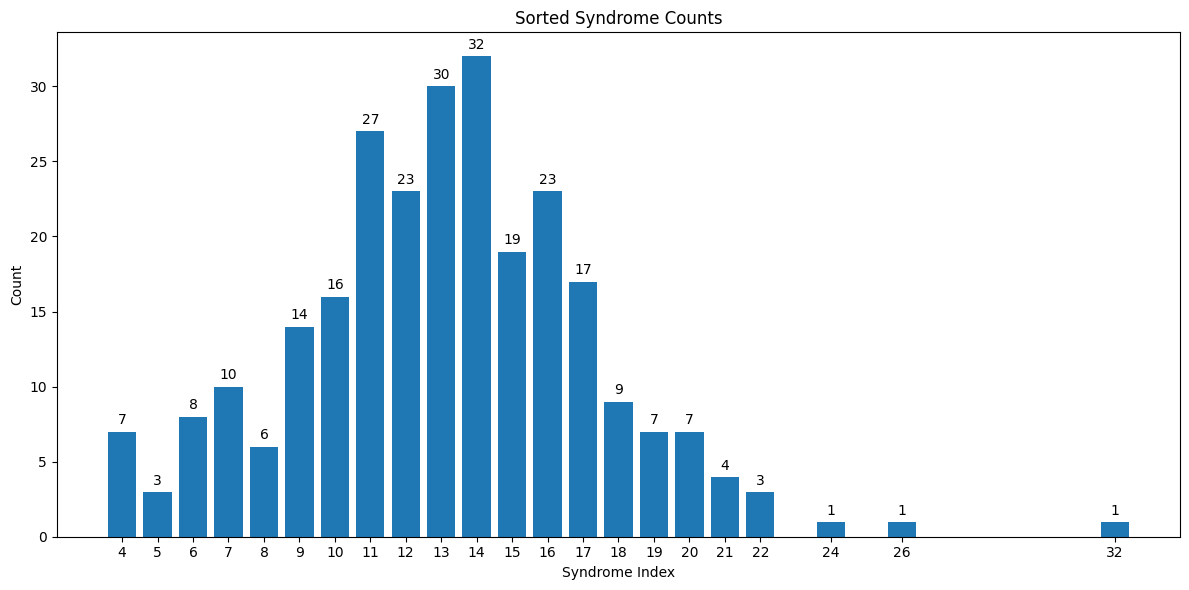

In [ ]:
# nkd =  [72, 12, 6]
# nkd =  [90, 8, 10]
nkd =  [144, 12, 12]
d = nkd[2] 
r = 1
p = 10
noise_model = "si1000"
error_type="Z"
num_runs=1
data_path="../data/external/eamld_experiment_data/paper_experiment_bb_codes"
code_name = "qldpc code"


from eamld.benchmark import generate_qldpc_detector_error_model
import eamld

# approximatestrategy = "no_no"
# approximate_param = None
approximatestrategy = "hyperedge_topk"
approximate_param = 1000

dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=data_path)
decoder_function =  eamld.EAMLD(detector_error_model=dem,
                            order_method='greedy',
                            slice_method='no_slice',
                            use_approx = True,
                            approximatestrategy = approximatestrategy,
                            approximate_param = approximate_param,
                            contraction_code = "qldpc-priority",
                            accuracy = "float64",
                            priority=1,
                            priority_topk=100)

baseline_decoder_function = None

analyze_result = analyze_decode_performance(decoder_function, baseline_decoder_function, d, nkd, r, p, noise_model, error_type, num_runs, data_path, code_name)

result = classify_by_hamming_weight(analyze_result)
visualize_syndrome_counts(result)

## 新的优先级，调整参数。

2025-04-14 10:36:11,656 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-14 10:36:11,657 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 90)...
2025-04-14 10:36:12,094 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 90) 预处理时间为：0.43701910972595215
2025-04-14 10:54:18,243 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 105/1000000 mistakes, num_unique_shots is 265987, error rate: 0.000105
2025-04-14 10:54:18,248 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 1086.5913 seconds - Error rate: 0.000105
2025-04-14 10:54:18,249 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.000105


finish decoding
finish sample_decode
sample decode error rate: 0.0
finish baseline decoding
finsih analyze


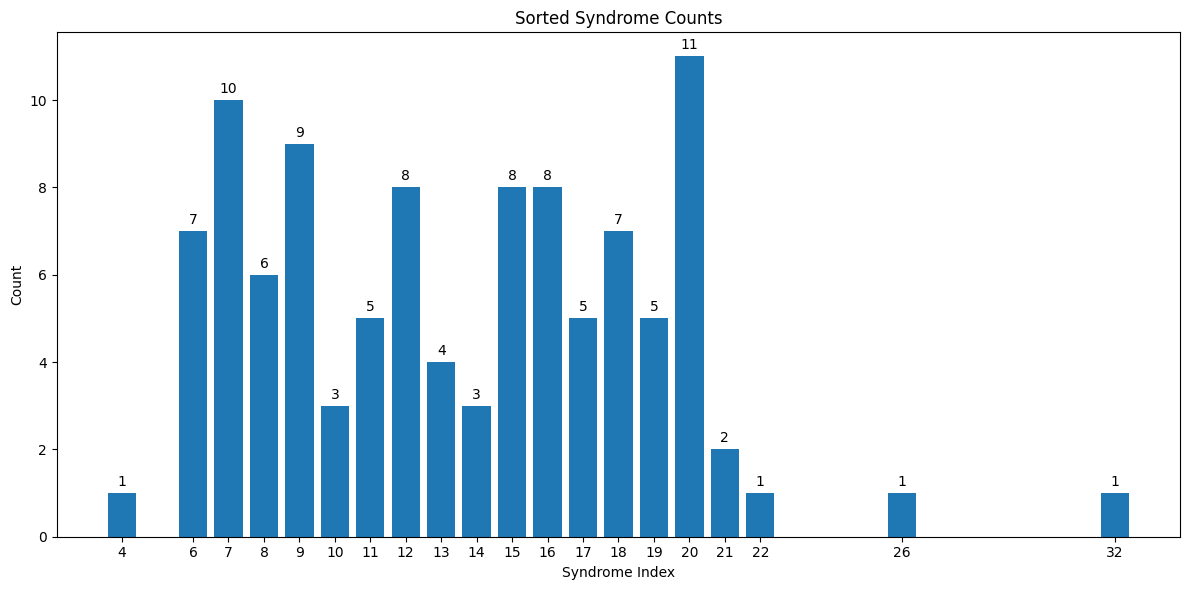

In [ ]:
# nkd =  [72, 12, 6]
nkd =  [90, 8, 10]
d = nkd[2] 
r = 1
p = 10
noise_model = "si1000"
error_type="Z"
num_runs=1
data_path="../data/external/eamld_experiment_data/paper_experiment_bb_codes"
code_name = "qldpc code"


from eamld.benchmark import generate_qldpc_detector_error_model
import eamld

# approximatestrategy = "no_no"
# approximate_param = None
approximatestrategy = "hyperedge_topk"
approximate_param = 1000

dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=data_path)
decoder_function =  eamld.EAMLD(detector_error_model=dem,
                            order_method='greedy',
                            slice_method='no_slice',
                            use_approx = True,
                            approximatestrategy = approximatestrategy,
                            approximate_param = approximate_param,
                            contraction_code = "qldpc-new-priority",
                            accuracy = "float64",
                            priority = -3,
                            priority_topk=200)

baseline_decoder_function = None

analyze_result = analyze_decode_performance(decoder_function, baseline_decoder_function, d, nkd, r, p, noise_model, error_type, num_runs, data_path, code_name)

result = classify_by_hamming_weight(analyze_result)
visualize_syndrome_counts(result)

# log处理

将其处理为类似MWPM的问题。

In [ ]:
nkd =  [72, 12, 6]
# nkd =  [90, 8, 10]
d = nkd[2] 
r = 1
p = 10
noise_model = "si1000"
error_type="Z"
num_runs=1
data_path="../data/external/eamld_experiment_data/paper_experiment_bb_codes"
code_name = "qldpc code"


from eamld.benchmark import generate_qldpc_detector_error_model
import eamld

# approximatestrategy = "no_no"
# approximate_param = None
approximatestrategy = "hyperedge_topk"
approximate_param = 800

# approximatestrategy = "hyperedge_threshold"
# approximate_param = -10**4

dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=data_path)
decoder_function =  eamld.EAMLD(detector_error_model=dem,
                            order_method='greedy',
                            slice_method='no_slice',
                            use_approx = True,
                            approximatestrategy = approximatestrategy,
                            approximate_param = approximate_param,
                            contraction_code = "qldpc-log",
                            accuracy = "float64",
                            priority = -2,
                            priority_topk=150)

baseline_decoder_function = None

analyze_result = analyze_decode_performance(decoder_function, baseline_decoder_function, d, nkd, r, p, noise_model, error_type, num_runs, data_path, code_name)

result = classify_by_hamming_weight(analyze_result)
visualize_syndrome_counts(result)

2025-04-17 13:23:49,216 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-17 13:23:49,217 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(10000000, 72)...
2025-04-17 13:23:52,823 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(10000000, 72) 预处理时间为：3.6050944328308105
2025-04-17 14:00:20,955 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 5395/10000000 mistakes, num_unique_shots is 1140040, error rate: 0.000540
2025-04-17 14:00:20,964 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 2191.7475 seconds - Error rate: 0.000540
2025-04-17 14:00:20,965 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.000540


finish decoding


KeyboardInterrupt: 

# d=r

In [ ]:
# nkd =  [72, 12, 6]
nkd =  [90, 8, 10]
# nkd =  [144, 12, 12]
d = nkd[2] 
r = d
p = 10
noise_model = "si1000"
error_type="Z"
num_runs=1
data_path="../data/external/eamld_experiment_data/paper_experiment_bb_codes"
code_name = "qldpc code"


from eamld.benchmark import generate_qldpc_detector_error_model
from stimbposd import BPOSD

dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=data_path)


max_bp_iters = 100
bp_osd_decoder  = BPOSD(dem, max_bp_iters = max_bp_iters)

baseline_decoder_function = None

analyze_result = analyze_decode_performance(bp_osd_decoder, baseline_decoder_function, d, nkd, r, p, noise_model, error_type, num_runs, data_path, code_name)

result = classify_by_hamming_weight(analyze_result)
visualize_syndrome_counts(result)